# General information
This notebook explains the following DANDIset:
https://dandiarchive.org/dandiset/000168/

Please read the paper for additional information:
https://doi.org/10.1101/2021.11.08.467793 

This notebook is available here:
https://raw.githubusercontent.com/rozmar/jGCaMP8_mouse_cell_attached_pipeline/master/NWB_tutorial.ipynb

# Install dependencies:
Install anaconda, open an Anaconda powershell prompt (or terminal in linux) and write the following:
```
conda create --name GCaMP8Mouse dandi pynwb h5py hdf5 matplotlib python=3.8 --channel=conda-forge
conda activate GCaMP8Mouse
pip install nwbwidgets jupyterlab
```

# Dataset description

This dataset contains simultaneous 2-photon calcium imaging movies and loose-seal cell attached recordings of upper layer 2 pyramidal cells and interneurons of the primary visual cortex of wild type mouse, in vivo, during drifting gratings stimulus in the contralateral eye.
jGCaMP8f, jGCaMP8m, jGCaMP8s, jGCaMP7f and XCaMPgf were expressed via AAV injections using synapsin-1 promoter.

Multiple neruons were recorded in each mouse, and multiple ~3-minutes-long recordings (movies/sweeps) were performed for each cell. One .nwb file contains all the data for a given cell. 

The dataset contains:
- raw 2-photon movies
- raw cell attached loose-seal electrophysiology traces of a single neuron in the field of view
- somatic cellular and neuropil ROIs that were segmented with Suite2p
- the fluorescence traces for all ROIs
- details of the drifting gratings stimuli presented to the contralateral eye



## Download data (optional)
You can either stream data from DANDI archives, download the whole dataset, or download the data of a single cell. <br>
If you wish to download the whole dataset (1.4 TB) locally, please go to the desired download directory in the command line, then enter:
```
dandi download DANDI:000168
```
Please refer to (https://www.dandiarchive.org/handbook/10_using_dandi/) for more details. <br>
Alternatively, this tutorial describes below how to stream the data or download the data of a single cell of interest.

### Load necessary libraries
These libraries are necessary for this script, please install if not available (see dependencies above). To import them, run the cell below.

In [2]:
dandiset_id = "000168"
version = "draft"

import pynwb
import requests
try:
    from nwbwidgets import nwb2widget
except:
    print('nwbwidgets is not installed - this functinality will be missing from the notebook')
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
import numpy as np
import scipy.ndimage as ndimage
import os
%matplotlib inline
from PIL import Image
from pathlib import Path
try:
    from ScanImageTiffReader import ScanImageTiffReader
except:
    pass
def gaussFilter(sig,sRate,sigma = .01):
    si = 1/sRate
    sig_f = ndimage.gaussian_filter(sig,sigma/si)
    return sig_f

def read_tiff(path, n_images=1000000):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)

    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            img.getpixel((1, 1))
            images.append(np.array(img))
        except EOFError:
            # Not enough frames in img
            break
    return np.array(images)

def _search_assets(url, filepath):
    filepath = filepath.replace(os.sep,'/')
    response = requests.request("GET", url, headers={"Accept": "application/json"}).json() 
    for asset in response["results"]:
        if filepath == asset["path"]:
            return asset["asset_id"]
    if response.get("next", None):
        return _search_assets(response["next"], filepath)
    raise ValueError(f'path {filepath} not found in dandiset {dandiset_id}.')


def get_asset_id(dandiset_id, version, filepath):
    filepath = filepath.replace(os.sep,'/')
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/{version}/assets/"
    return _search_assets(url, filepath)

def get_s3_url(dandiset_id, version, filepath):
    filepath = filepath.replace(os.sep,'/')
    """Get the s3 location for any NWB file on DANDI"""
    asset_id = get_asset_id(dandiset_id, version, filepath)
    url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/{version}/assets/{asset_id}/download/"
    s3_url = requests.request(url=url, method='head').url
    if '?' in s3_url:
        return s3_url[:s3_url.index('?')]
    return s3_url

### In case you want to stream the data please run the cell below
We suggest using this method with fast internet connection or on DANDIHUB (http://hub.dandiarchive.org). For a quick walktrough how to use dandihub, please see the following video: https://youtu.be/8OMLmUnc6Cs?t=3060

In [3]:
stream_data = True 

### In case you use local files, please complete and run the cell below
Note that this script assumes that the files in the base directory has the same directory structure as in the dandiset (e.g. you have downloaded the whole dataset). By default, the data will be downloaded in the working directory, where this jupyter notebook resides.

In [21]:
stream_data = False
base_dir_ = os.path.join(os.getcwd(),'DandiSet_000168')
### !! edit the "base_dir_" variable here if you want to change the download directory or you have already downloaded the dandiset###
#base_dir_ = '/home/rozmar/Data/DandiSets/000168/' # this points to the root directory of the dandiset
### EDIT THIS VARIABLE IF YOU WANT TO CHANGE THE SAVE DIRECTORY ###

### Select Subject ID and cell number
The name of the sensor expressed by the recorded cell is also in the file name, please change that accordingly, use the table below or look up the name of the .nwb file. <br>

| Sensor | Subject ID | Cell number | Putative cell type (pyr/int) | Total recording length (sec) | Recording mode (current clamp / voltage clamp) | Total action potential number | Median action potential signal-to-noise ratio |
| :---:  | :---: | :---:  | :---: | :---: | :---: | :---: |  :---: |
|jGCaMP8f | 471993 | 0 | pyr | 800.1 | cc & vc | 619 | 55.82 |
|jGCaMP8f | 471993 | 1 | pyr | 960.13 | cc | 481 | 55.14 |
|jGCaMP8f | 471993 | 2 | pyr | 1440.25 | cc | 1975 | 268.39|
|jGCaMP8f | 471994 | 0 | pyr | 817.29 | cc | 1688 | 222.15|
|jGCaMP8f | 471994 | 1 | pyr | 480.06 | cc | 75 | 111.48|
|jGCaMP8f | 471994 | 2 | pyr | 160.03 | cc | 46 | 380.92|
|jGCaMP8f | 471994 | 3 | pyr | 320.06 | vc | 139 | 50.38|
|jGCaMP8f | 471994 | 4 | pyr | 800.18 | cc | 576 | 120.48|
|jGCaMP8f | 471994 | 5 | pyr | 160.04 | cc | 50 | 133.75|
|jGCaMP8f | 471994 | 6 | pyr | 1280.35 | cc | 1424 | 231.98|
|jGCaMP8f | 471994 | 7 | pyr | 160.05 | cc | 123 | 76.3|
|jGCaMP8f | 478342 | 0 | pyr | 320.09 | vc | 269 | 185.16|
|jGCaMP8f | 478342 | 2 | pyr | 320.09 | vc | 283 | 68.48|
|jGCaMP8f | 478342 | 3 | int | 320.1 | cc | 1016 | 261.53|
|jGCaMP8f | 478348 | 0 | pyr | 960.21 | cc | 430 | 100.27|
|jGCaMP8f | 478349 | 0 | pyr | 974.96 | cc | 1253 | 433.83|
|jGCaMP8f | 478349 | 1 | pyr | 960.24 | cc | 635 | 201.54|
|jGCaMP8f | 478349 | 2 | pyr | 320.08 | cc | 31 | 98.45|
|jGCaMP8f | 478349 | 3 | pyr | 640.17 | cc | 170 | 311.6|
|jGCaMP8f | 478349 | 4 | pyr | 320.09 | cc | 190 | 184.68|
|jGCaMP8f | 478349 | 5 | int | 320.09 | cc | 6656 | 134.21|
|jGCaMP8f | 478349 | 6 | pyr | 1600.43 | cc | 2553 | 196.92|
|jGCaMP8f | 478407 | 0 | pyr | 1280.22 | cc | 1536 | 131.65|
|jGCaMP8f | 478407 | 1 | pyr | 320.06 | cc | 94 | 147.07|
|jGCaMP8f | 478407 | 2 | pyr | 320.07 | cc & vc | 153 | 53.19|
|jGCaMP8f | 478407 | 3 | pyr | 320.07 | cc | 169 | 158.67|
|jGCaMP8f | 478407 | 4 | pyr | 160.04 | cc | 39 | 60.96|
|jGCaMP8f | 478407 | 5 | int | 320.08 | vc | 1236 | 78.19|
|jGCaMP8f | 478407 | 6 | pyr | 320.08 | vc | 369 | 89.35|
|jGCaMP8f | 478410 | 0 | pyr | 320.07 | cc | 34 | 131.33|
|jGCaMP8f | 478410 | 2 | pyr | 640.16 | cc | 143 | 78.2|
|jGCaMP8f | 478410 | 3 | pyr | 320.08 | cc | 91 | 193.18|
|jGCaMP8f | 478410 | 4 | pyr | 480.12 | cc | 336 | 158.52|
|jGCaMP8f | 478410 | 5 | pyr | 320.08 | cc | 688 | 132.81|
|jGCaMP8f | 478411 | 0 | pyr | 1282.7 | cc | 675 | 282.52|
|jGCaMP8f | 478411 | 1 | pyr | 800.18 | cc & vc | 992 | 80.17|
|jGCaMP8f | 478411 | 2 | pyr | 800.18 | cc & vc | 309 | 63.34|
|jGCaMP8f | 478411 | 3 | pyr | 640.16 | cc | 82 | 110.57|
|jGCaMP8f | 478411 | 4 | pyr | 160.05 | cc | 13 | 34.47|
|jGCaMP8f | 478411 | 5 | pyr | 480.14 | cc & vc | 195 | 80.34|
|jGCaMP8m | 472179 | 0 | int | 487.46 | cc | 3614 | 59.4|
|jGCaMP8m | 472179 | 1 | pyr | 649.96 | cc | 474 | 124.68|
|jGCaMP8m | 472179 | 2 | pyr | 1127.61 | cc | 1357 | 72.71|
|jGCaMP8m | 472179 | 3 | pyr | 640.14 | cc | 1089 | 74.76|
|jGCaMP8m | 472179 | 4 | pyr | 320.08 | cc | 787 | 245.11|
|jGCaMP8m | 472180 | 0 | int | 1137.39 | cc | 14948 | 157.5|
|jGCaMP8m | 472180 | 1 | pyr | 812.44 | cc | 1230 | 105.09|
|jGCaMP8m | 472180 | 2 | pyr | 974.98 | cc | 1269 | 252.81|
|jGCaMP8m | 472180 | 3 | pyr | 960.22 | cc | 1148 | 239.05|
|jGCaMP8m | 472180 | 4 | pyr | 160.03 | cc | 235 | 350.59|
|jGCaMP8m | 472180 | 5 | pyr | 1280.29 | cc | 529 | 78.64|
|jGCaMP8m | 479115 | 0 | pyr | 1207.35 | cc | 475 | 162.99|
|jGCaMP8m | 479115 | 1 | pyr | 172.48 | cc | 131 | 91.25|
|jGCaMP8m | 479115 | 2 | pyr | 169.86 | cc | 47 | 54.34|
|jGCaMP8m | 479115 | 3 | pyr | 339.76 | cc & vc | 158 | 126.46|
|jGCaMP8m | 479115 | 4 | pyr | 679.52 | cc & vc | 190 | 60.06|
|jGCaMP8m | 479115 | 5 | pyr | 849.4 | cc & vc | 1506 | 244.58|
|jGCaMP8m | 479115 | 6 | pyr | 339.76 | cc | 94 | 74.63|
|jGCaMP8m | 479115 | 7 | pyr | 169.89 | cc | 26 | 158.21|
|jGCaMP8m | 479115 | 8 | pyr | 1359.09 | cc | 2142 | 199.58|
|jGCaMP8m | 479117 | 0 | pyr | 1280.25 | cc | 2825 | 246.23|
|jGCaMP8m | 479117 | 1 | pyr | 1120.27 | cc & vc | 477 | 89.17|
|jGCaMP8m | 479117 | 2 | pyr | 640.17 | cc & vc | 331 | 88.82|
|jGCaMP8m | 479117 | 3 | pyr | 320.08 | cc | 59 | 134.17|
|jGCaMP8m | 479117 | 4 | pyr | 800.23 | cc | 763 | 158.82|
|jGCaMP8m | 479117 | 5 | pyr | 1280.35 | cc | 678 | 208.96|
|jGCaMP8m | 479117 | 6 | pyr | 640.19 | cc | 180 | 79.49|
|jGCaMP8m | 479118 | 0 | pyr | 480.07 | cc | 206 | 52.14|
|jGCaMP8m | 479118 | 1 | pyr | 960.17 | cc | 1621 | 179.47|
|jGCaMP8m | 479118 | 2 | pyr | 640.13 | cc & vc | 4790 | 85.95|
|jGCaMP8m | 479118 | 3 | pyr | 800.18 | cc | 208 | 116.5|
|jGCaMP8m | 479118 | 4 | pyr | 640.15 | vc | 544 | 129.52|
|jGCaMP8m | 479118 | 5 | pyr | 960.23 | cc | 287 | 95.12|
|jGCaMP8m | 479569 | 0 | pyr | 335.12 | cc | 57 | 49.62|
|jGCaMP8m | 479569 | 1 | pyr | 345.3 | vc | 145 | 45.99|
|jGCaMP8m | 479569 | 2 | pyr | 1208.59 | cc | 370 | 252.11|
|jGCaMP8m | 479569 | 3 | pyr | 1208.61 | cc | 357 | 144.76|
|jGCaMP8m | 479569 | 4 | pyr | 170.03 | cc | 57 | 37.69|
|jGCaMP8m | 479569 | 5 | pyr | 1190.28 | cc | 166 | 159.48|
|jGCaMP8m | 479569 | 6 | pyr | 680.16 | cc | 264 | 165.01|
|jGCaMP8m | 479569 | 7 | pyr | 510.13 | cc | 71 | 70.01|
|jGCaMP8m | 479570 | 0 | pyr | 670.1 | cc | 149 | 68.94|
|jGCaMP8m | 479570 | 1 | pyr | 340.07 | cc | 142 | 80.13|
|jGCaMP8m | 479570 | 2 | pyr | 1020.23 | cc | 375 | 168.97|
|jGCaMP8m | 479570 | 3 | pyr | 1360.33 | cc | 232 | 268.23|
|jGCaMP8m | 479570 | 4 | pyr | 510.13 | cc | 287 | 211.04|
|jGCaMP8m | 479570 | 5 | pyr | 680.18 | cc & vc | 3118 | 110.6|
|jGCaMP8s | 472181 | 0 | pyr | 1137.4 | cc | 1612 | 100.82|
|jGCaMP8s | 472181 | 1 | pyr | 1462.38 | cc | 1436 | 104.19|
|jGCaMP8s | 472181 | 2 | pyr | 1462.45 | cc | 1075 | 245.6|
|jGCaMP8s | 472181 | 3 | pyr | 640.13 | cc | 1335 | 136.77|
|jGCaMP8s | 472181 | 4 | pyr | 1760.4 | cc | 2395 | 166.32|
|jGCaMP8s | 472182 | 0 | pyr | 1120.2 | cc | 304 | 190.05|
| **jGCaMP8s** | **472182** | **1** | pyr | 480.09 | cc | 1057 | 194.27|
|jGCaMP8s | 472182 | 3 | pyr | 160.03 | cc | 31 | 235.39|
|jGCaMP8s | 472182 | 4 | int | 640.12 | cc | 5509 | 152.36|
|jGCaMP8s | 472182 | 5 | pyr | 320.06 | cc | 81 | 83.61|
|jGCaMP8s | 472182 | 6 | pyr | 960.21 | cc | 517 | 184.86|
|jGCaMP8s | 472182 | 7 | pyr | 960.24 | cc | 4441 | 52.12|
|jGCaMP8s | 472182 | 8 | pyr | 160.04 | cc | 173 | 52.65|
|jGCaMP8s | 479116 | 0 | pyr | 162.48 | cc | 353 | 342.98|
|jGCaMP8s | 479116 | 1 | pyr | 1280.24 | cc | 334 | 138.65|
|jGCaMP8s | 479116 | 2 | pyr | 960.22 | cc | 567 | 86.35|
|jGCaMP8s | 479116 | 3 | pyr | 960.24 | cc | 143 | 95.43|
|jGCaMP8s | 479116 | 4 | int | 1120.28 | cc & vc | 3809 | 113.77|
|jGCaMP8s | 479116 | 5 | int | 1280.33 | cc & vc | 3333 | 73.18|
|jGCaMP8s | 479119 | 0 | pyr | 1120.16 | cc | 245 | 87.12|
|jGCaMP8s | 479119 | 1 | pyr | 1120.2 | cc | 639 | 93.38|
|jGCaMP8s | 479119 | 2 | pyr | 1120.22 | cc | 1731 | 189.24|
|jGCaMP8s | 479119 | 3 | pyr | 640.13 | cc | 172 | 62.21|
|jGCaMP8s | 479119 | 4 | pyr | 320.07 | cc | 1233 | 43.26|
|jGCaMP8s | 479119 | 5 | pyr | 960.21 | cc & vc | 434 | 150.42|
|jGCaMP8s | 479119 | 6 | int | 480.1 | cc | 359 | 87.38|
|jGCaMP8s | 479119 | 7 | int | 800.17 | cc | 7871 | 65.24|
|jGCaMP8s | 479119 | 8 | int | 1280.3 | cc | 3420 | 186.9|
|jGCaMP8s | 479120 | 0 | pyr | 1120.16 | cc | 668 | 53.31|
|jGCaMP8s | 479120 | 1 | pyr | 640.11 | cc & vc | 1173 | 262.04|
|jGCaMP8s | 479120 | 2 | pyr | 160.03 | cc | 43 | 197.55|
|jGCaMP8s | 479120 | 3 | pyr | 160.03 | cc | 20 | 443.87|
|jGCaMP8s | 479120 | 5 | pyr | 960.18 | cc | 860 | 50.11|
|jGCaMP8s | 479120 | 6 | pyr | 160.03 | cc | 87 | 235.09|
|jGCaMP8s | 479120 | 7 | pyr | 640.13 | cc & vc | 1513 | 177.49|
|jGCaMP8s | 479571 | 1 | pyr | 170.03 | cc | 209 | 162.41|
|jGCaMP8s | 479571 | 3 | int | 1190.27 | cc & vc | 15009 | 227.64|
|jGCaMP8s | 479571 | 4 | pyr | 1190.32 | cc | 1786 | 67.27|
|jGCaMP8s | 479571 | 5 | pyr | 1360.34 | cc | 415 | 418.1|
|jGCaMP8s | 479571 | 6 | pyr | 850.22 | cc & vc | 458 | 138.12|
|jGCaMP8s | 479572 | 0 | pyr | 680.1 | cc | 2937 | 262.51|
|jGCaMP8s | 479572 | 1 | pyr | 510.08 | cc | 700 | 83.33|
|jGCaMP8s | 479572 | 2 | pyr | 170.03 | cc | 468 | 205.84|
|jGCaMP8s | 479572 | 3 | pyr | 1360.25 | cc | 218 | 191.49|
|jGCaMP8s | 479572 | 4 | pyr | 850.16 | cc | 366 | 82.56|
|jGCaMP8s | 479572 | 5 | int | 170.03 | vc | 743 | 153.4|
|jGCaMP8s | 479572 | 6 | int | 170.03 | cc | 420 | 31.6|
|jGCaMP8s | 479572 | 7 | pyr | 170.03 | cc | 135 | 166.24|
|jGCaMP8s | 479572 | 8 | pyr | 1360.32 | cc | 425 | 223.99|
|jGCaMP7f | 471991 | 0 | pyr | 640.07 | vc | 344 | 114.5|
|jGCaMP7f | 471991 | 1 | pyr | 160.02 | vc | 76 | 42.55|
|jGCaMP7f | 471991 | 2 | pyr | 160.03 | vc | 41 | 211.43|
|jGCaMP7f | 471991 | 3 | pyr | 320.05 | cc & vc | 55 | 56.47|
|jGCaMP7f | 471991 | 4 | pyr | 1920.29 | cc | 1231 | 250.95|
|jGCaMP7f | 478346 | 0 | int | 320.09 | cc | 779 | 44.01|
|jGCaMP7f | 478347 | 0 | pyr | 640.16 | cc | 60 | 72.06|
|jGCaMP7f | 478347 | 1 | pyr | 320.09 | cc | 341 | 51.27|
|jGCaMP7f | 478347 | 3 | pyr | 320.09 | cc | 100 | 128.57|
|jGCaMP7f | 478404 | 0 | pyr | 960.19 | cc & vc | 604 | 228.27|
|jGCaMP7f | 478404 | 1 | pyr | 160.04 | cc | 104 | 68.36|
|jGCaMP7f | 478404 | 2 | pyr | 480.11 | cc & vc | 176 | 56.38|
|jGCaMP7f | 478404 | 3 | pyr | 160.04 | cc | 16 | 119.89|
|jGCaMP7f | 478404 | 4 | pyr | 480.14 | cc | 153 | 240.01|
|jGCaMP7f | 478404 | 5 | pyr | 160.05 | cc | 17 | 154.97|
|jGCaMP7f | 478404 | 6 | pyr | 480.15 | vc | 334 | 101.05|
|jGCaMP7f | 478406 | 0 | pyr | 457.94 | cc | 1036 | 286.46|
|jGCaMP7f | 478406 | 2 | pyr | 160.04 | cc | 207 | 218.54|
|jGCaMP7f | 478406 | 3 | pyr | 480.14 | cc | 123 | 82.75|
|jGCaMP7f | 478406 | 4 | pyr | 800.25 | cc | 1452 | 251.99|
|jGCaMP7f | 478406 | 5 | pyr | 480.16 | cc | 223 | 139.41|
|jGCaMP7f | 478406 | 6 | pyr | 320.1 | cc | 285 | 124.07|
|jGCaMP7f | 478406 | 7 | pyr | 480.15 | cc | 55 | 103.83|
|XCaMP-Gf | 471996 | 0 | pyr | 800.05 | cc | 8312 | 416.15|
|XCaMP-Gf | 478343 | 0 | int | 487.51 | cc | 2939 | 39.14|
|XCaMP-Gf | 478343 | 1 | int | 645.09 | cc | 10106 | 128.15|
|XCaMP-Gf | 478343 | 2 | pyr | 480.15 | vc | 645 | 130.4|
|XCaMP-Gf | 478343 | 3 | pyr | 160.05 | cc | 42 | 130.77|
|XCaMP-Gf | 478343 | 4 | pyr | 640.2 | cc | 135 | 60.64|
|XCaMP-Gf | 478343 | 5 | pyr | 160.05 | cc | 247 | 59.39|
|XCaMP-Gf | 478343 | 6 | pyr | 160.05 | vc | 126 | 76.43|
|XCaMP-Gf | 478345 | 0 | pyr | 320.07 | cc | 194 | 254.02|
|XCaMP-Gf | 478345 | 2 | pyr | 640.15 | cc | 471 | 167.2|
|XCaMP-Gf | 478345 | 3 | pyr | 320.09 | cc | 35 | 88.3|


In [6]:
### EDIT THESE VARIABLES TO USE DIFFERENT PARTS OF THE DATASET ###
sensor = 'jGCaMP8s' #name of the sensor in that experiment (jGCaMP8s/jGCaMP8m/jGCaMP8f/jGCaMP7f/XCaMPgf)
subject_id = 472182 #ID of the mouse
cell_number = 1 #ID of the cell in this subject
gauss_filter_sigma = 10 #ms - only to make the final plot smoother
### EDIT THESE VARIABLES TO USE DIFFERENT PARTS OF THE DATASET ###

if stream_data:
    filepath = os.path.join(sensor,'{}_ANM{}_cell{}.nwb'.format(sensor,subject_id,str(cell_number).zfill(2)))
    s3_path = get_s3_url(dandiset_id, version, filepath)
    #io = pynwb.NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')
else:
    base_dir = os.path.join(base_dir_,sensor)
    nwbfile = os.path.join(base_dir,'{}_ANM{}_cell{}.nwb'.format(sensor,subject_id,str(cell_number).zfill(2)))
    if not os.path.exists(nwbfile):
        filepath = os.path.join(sensor,'{}_ANM{}_cell{}.nwb'.format(sensor,subject_id,str(cell_number).zfill(2)))
        Path(base_dir).mkdir(parents=True, exist_ok=True)
        asset_id = get_asset_id(dandiset_id, version, filepath)
        dandi_url = f"https://api.dandiarchive.org/api/dandisets/{dandiset_id}/versions/{version}/assets/{asset_id}/download/"
        os.chdir(base_dir)
        print('downloading data for the selected cell, this will take a while depending on file size and your internet connection, sit tight!')
        ! dandi download $dandi_url
    io = pynwb.NWBHDF5IO(nwbfile, 'r')
    
nwbfile = io.read()

print('Available movies are: {}'.format(list(nwbfile.imaging_planes.keys())))

downloading data for the selected cell, sit tight..
PATH                          SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
jGCaMP8s_ANM472182_cell01.nwb 14.5 GB  14.5 GB          100%    ok    done                   
Summary:                      14.5 GB  14.5 GB                        1 done                 
                                       100.00%                                               
2022-04-29 12:38:36,397 [    INFO] Logs saved in /home/rozmar/.cache/dandi-cli/log/20220429190511Z-718530.log
Available movies are: ['Movie_0', 'Movie_1', 'Movie_2', 'Movie_3', 'Movie_4', 'Movie_5', 'Movie_6']


The .nwb file contains rich metadata about the devices, mouse, virus injection..

In [7]:
nwb2widget(nwbfile)

In [8]:
print(nwbfile)

root pynwb.file.NWBFile at 0x140074604503680
Fields:
  acquisition: {
    Registered movie 0 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 1 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 2 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 3 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 4 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 5 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Registered movie 6 <class 'pynwb.ophys.TwoPhotonSeries'>,
    loose seal recording for movie 0 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 1 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 2 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 3 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 4 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose seal recording for movie 5 <class 'pynwb.icephys.CurrentClampSeries'>,
    loose 

# Select a movie from the imaging planes.
Available movie numbers are in the output of the cells above.

In [9]:
### EDIT THIS VARIABLE ###
movie_number = 3
### EDIT THIS VARIABLE ###

if 'Movie_{}'.format(movie_number) not in nwbfile.imaging_planes.keys():
    print('!!! Not a valid movie number, please choose from: {}'.format(list(nwbfile.imaging_planes.keys())))

# Imaging plane
The imaging plane contains metadata about the experiment, now we will use only the pixel size in this example

In [10]:
imaging_plane = nwbfile.imaging_planes['Movie_{}'.format(movie_number)]
print(imaging_plane)
movie_pixel_size = imaging_plane.grid_spacing[0]

Movie_3 pynwb.ophys.ImagingPlane at 0x140074604739408
Fields:
  conversion: 1.0
  description: Simultaneous loose-seal recording and calcium imaging in V1
  device: MMIMS: custom-built two-photon microscope with a resonant scanner pynwb.device.Device at 0x140074605083616
  excitation_lambda: 940.0
  imaging_rate: 121.97100240805149
  indicator: jGCaMP8s
  location: V1
  optical_channel: (
    green <class 'pynwb.ophys.OpticalChannel'>
  )
  reference_frame: surface of the cortex
  unit: meters



# Ophys
The following lines show how to extract the mean image of the selected movie, the ROI and neuropil traces and the ROI and neuropil pixels. To make the data easier to interpret, we do neuropil correction, dF/F is calculated, and a gaussian filter is applied to the extracted traces. The ROI that is recorded with ephys is also labelled, it is also always the first ROI.

In [11]:
ophys = nwbfile.processing['ophys of movie {}'.format(movie_number)]

meanimages = ophys['mean images of movie {}'.format(movie_number)]
mean_image_GCaMP = meanimages.images['{} at 940nm'.format(sensor)].data[:] # imshow expects(y,x), NWB uses (x,y)

roi_traces = ophys['Fluorescence']['RoiResponseSeries'].data[:]
neuropil_traces = ophys['Fluorescence']['NeuropilResponseSeries'].data[:]

recorded_with_ephys = ophys['ImageSegmentation']['MovieSegmentation']['recorded_with_ephys'].data[:]
putative_cell_type = ophys['ImageSegmentation']['MovieSegmentation']['cell_type'].data[:]
roi_time = ophys['Fluorescence']['RoiResponseSeries'].timestamps[:]
roi_dff_list = []
for roi_i,(roi_trace,neuropil_trace,recorded_cell,cell_type) in enumerate(zip(roi_traces,neuropil_traces,recorded_with_ephys,putative_cell_type)):
    f_corrected = roi_trace-0.8*neuropil_trace
    f0 = np.percentile(f_corrected,20)
    dff = (f_corrected-f0)/f0
    dff = gaussFilter(dff,imaging_plane.imaging_rate,sigma = gauss_filter_sigma/1000)
    roi_dff_list.append(dff)  
    if recorded_cell:
        f_corrected_of_recorded_cell = f_corrected
        if cell_type == 'pyr':
            putative_cell_type = 'pyramidal cell'
        elif cell_type == 'int':
            putative_cell_type = 'interneuron'
        else:
            putative_cell_type = 'unknown'


roi_masks = ophys['ImageSegmentation']['MovieSegmentation']['image_mask'].data[:]
neuropil_masks = ophys['ImageSegmentation']['MovieSegmentation']['neuropil_mask'].data[:]

# This loop generates an image that shows the cellular and neuropil ROIs, and saves the center coordinates 
# for plotting purposes.
roi_image = np.zeros_like(mean_image_GCaMP)
roi_center_indices = []
for roi_i,(roi_now,neuropil_now) in enumerate(zip(roi_masks,neuropil_masks)):
    roi_image+=roi_now/np.max(roi_now)
    roi_image[neuropil_now>0] = -1*neuropil_now[neuropil_now>0]/np.max(neuropil_now)
    y_ind,x_ind = np.where(roi_now)
    roi_center_indices.append([np.median(x_ind),np.median(y_ind)])
print(ophys)

ophys of movie 3 pynwb.base.ProcessingModule at 0x140074604451200
Fields:
  data_interfaces: {
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    mean images of movie 3 <class 'pynwb.base.Images'>
  }
  description: Processing result of imaging



## Regsitered movie
The registered movies are part of the .nwb file. Let's access the first 5000 frames and show the mean image. This might take a while.

Note that the dimensions in NWB files are (x,y,z), while many other software, such as scanimage uses (z,y,x).

Text(0.5, 1.0, 'Mean of the first 5000 frames')

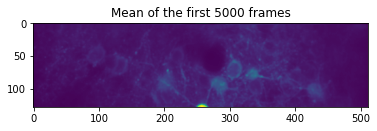

In [12]:
movie_reg = nwbfile.acquisition['Registered movie {}'.format(movie_number)].data[:5000,:,:] # the nwb dimensions are (x,y,z)
movie_reg_mean= np.mean(movie_reg,0)
plt.imshow(movie_reg_mean.T) # imshow expects (y,x)
plt.title('Mean of the first 5000 frames')

As a sanity check, let's use the first ROI mask to extract its trace from the raw movie, and overlay it with the ROI trace that was pre-packaged in this .nwb file.

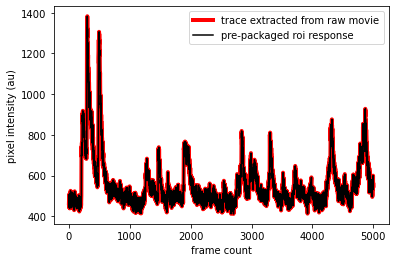

In [13]:
roi_now = ophys['ImageSegmentation']['MovieSegmentation']['image_mask'].data[0]

movie_flat =  np.reshape(movie_reg, (movie_reg.shape[0],-1))
roi_flat = roi_now.flatten()
f_extracted = np.dot(movie_flat[:,roi_flat>0], roi_flat[roi_flat>0]) # extract the trace from the movie

plt.plot(f_extracted, 'r-',linewidth = 4,label = 'trace extracted from raw movie')


f_pre_packaged = ophys['Fluorescence']['RoiResponseSeries'].data[0,:5000] # pre-packaged trace
plt.plot(f_pre_packaged, 'k-',label = 'pre-packaged roi response')
plt.ylabel('pixel intensity (au)')
plt.xlabel('frame count')
plt.legend()

# Ephys
The following lines show how to extract the raw electrophyisiolgy trace for the same movie selected above, the spike times and spike peak indices on the electrophysiology trace. The trace can either be in current clamp or in voltage clamp recording mode. 

We stimulated during some of the voltage clamp recordings, which can be seen on the stimulus trace, or on the artefacts of the response trace.

In [14]:
ephys = nwbfile.acquisition['loose seal recording for movie {}'.format(movie_number)]
ephys_trace = ephys.data[:]
if ephys.unit == 'volts':
    ephys_trace = ephys_trace*1000
    ephys_unit = 'mV'
else:
    ephys_trace = ephys_trace*1e12
    ephys_unit = 'pA'
ephys_time = np.arange(len(ephys_trace))/ephys.rate+ephys.starting_time
ap_times = nwbfile.analysis['responses']['ap_time'].data[:]
ap_times = ap_times[(ap_times>np.min(ephys_time)) &(ap_times<np.max(ephys_time))]
ap_indices = []
for ap_now in nwbfile.analysis['responses']['response'].data[:]:
    if ap_now[2].sweep_number==movie_number:
        ap_indices.append(ap_now[0])
ap_indices = np.asarray(ap_indices) 

print(ephys)

loose seal recording for movie 3 pynwb.icephys.CurrentClampSeries at 0x140074604768272
Fields:
  bias_current: 0.0
  bridge_balance: 0.0
  capacitance_compensation: 0.0
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (8198976,), type "<f8">
  description: no description
  electrode: Micropipette pynwb.icephys.IntracellularElectrode at 0x140074604769040
Fields:
  description: Micropipette (3–9 MOhm) filled with sterile saline containing 20 micromolar AlexaFluor 594
  device: Multiclamp 700B pynwb.device.Device at 0x140074604777824
Fields:
  description: Multiclamp 700B with 20 kHz low-pass filter
  manufacturer: Axon Instruments


  gain: 0.02
  rate: 50000.0
  resolution: nan
  starting_time: 620.575999
  starting_time_unit: seconds
  stimulus_description: N/A
  sweep_number: 3
  unit: volts



### Note that also the epochs table can be used to pair the ephys and ophys traces:
Each epoch is one movie with the corresponding ROI traces and electrophysiological recording.

In [15]:
nwbfile.epochs[:]

,start_time,stop_time,timeseries
id,,,
0,0.000000,165.091840,"[[0, 8254591, loose seal recording for movie 0..."
1,215.639999,381.531839,"[[0, 8294592, loose seal recording for movie 1..."
2,409.044000,574.596640,"[[0, 8277632, loose seal recording for movie 2..."
3,620.575999,784.555519,"[[0, 8198975, loose seal recording for movie 3..."
4,853.267999,1016.363039,"[[0, 8154752, loose seal recording for movie 4..."
5,1044.038999,1213.039959,"[[0, 8450048, loose seal recording for movie 5..."
6,1234.873000,1398.881960,"[[0, 8200448, loose seal recording for movie 6..."


# Drifting gratings visual stimulus
The information regarding the visual stimulus is in the trial field of the .nwb file. To select the visual stimuli during the selected movie, you can either use the timing of the visual stimuli or the "movie_number" column in the trials table.

The script below also calculates the tuning curve of the recorded neuron for this movie.

In [16]:
angle_list = []
apnum_list = []
dff_list = []
needed_trials = nwbfile.trials['movie_number'].data[:] == movie_number # these are the relevant trials for this movie
for stim_start_t_now,stim_end_t_now,a in zip(nwbfile.trials['start_time'].data[needed_trials],nwbfile.trials['stop_time'].data[needed_trials],nwbfile.trials['angle'].data[needed_trials]):
    angle_list.append(a)
    visual_stim_ap_num = np.sum((ap_times>stim_start_t_now)&(ap_times<stim_end_t_now))
    baseline_ap_num = np.sum((ap_times<stim_start_t_now)&(ap_times>stim_start_t_now-(stim_end_t_now-stim_start_t_now)))
    apnum_list.append(visual_stim_ap_num-baseline_ap_num)

    stim_start_imaging = np.argmax(roi_time>stim_start_t_now)
    if np.argmax(roi_time>stim_end_t_now)==0:  
        stim_end_imaging = len(roi_time) 
    else:  
        stim_end_imaging = np.argmax(roi_time>stim_end_t_now)
    recorded_roi_f = f_corrected_of_recorded_cell[stim_start_imaging:stim_end_imaging]
    recorded_roi_f0 = np.mean(f_corrected_of_recorded_cell[np.argmax(roi_time>stim_start_t_now-.7):np.argmax(roi_time>stim_start_t_now)])
    recorded_roi_dff = (recorded_roi_f-recorded_roi_f0)/recorded_roi_f0
    dff_list.append(np.mean(recorded_roi_dff[recorded_roi_dff>=np.percentile(recorded_roi_dff,75)]))
unique_angles = np.unique(angle_list)
dff_mean_list = []
dff_std_list = []

ap_mean_list = []
ap_std_list = []
for a in unique_angles:
    apnum_mean = np.mean(np.asarray(apnum_list)[np.asarray(angle_list)==a])
    apnum_std = np.std(np.asarray(apnum_list)[np.asarray(angle_list)==a])
    ap_mean_list.append(apnum_mean)
    ap_std_list.append(apnum_std)
    dff_mean_list.append(np.mean(np.asarray(dff_list)[np.asarray(angle_list)==a]))
    dff_std_list.append(np.std(np.asarray(dff_list)[np.asarray(angle_list)==a]))

print(nwbfile.trials)

trials pynwb.epoch.TimeIntervals at 0x140074604506032
Fields:
  colnames: ['start_time' 'stop_time' 'angle' 'cycles_per_second' 'cycles_per_degree'
 'amplitude' 'movie_number']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    angle <class 'hdmf.common.table.VectorData'>,
    cycles_per_second <class 'hdmf.common.table.VectorData'>,
    cycles_per_degree <class 'hdmf.common.table.VectorData'>,
    amplitude <class 'hdmf.common.table.VectorData'>,
    movie_number <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>



# Plot
Figures explaining the data in this .nwb file. There is more metadata in the file than what is plotted here. Please see figure legend below.

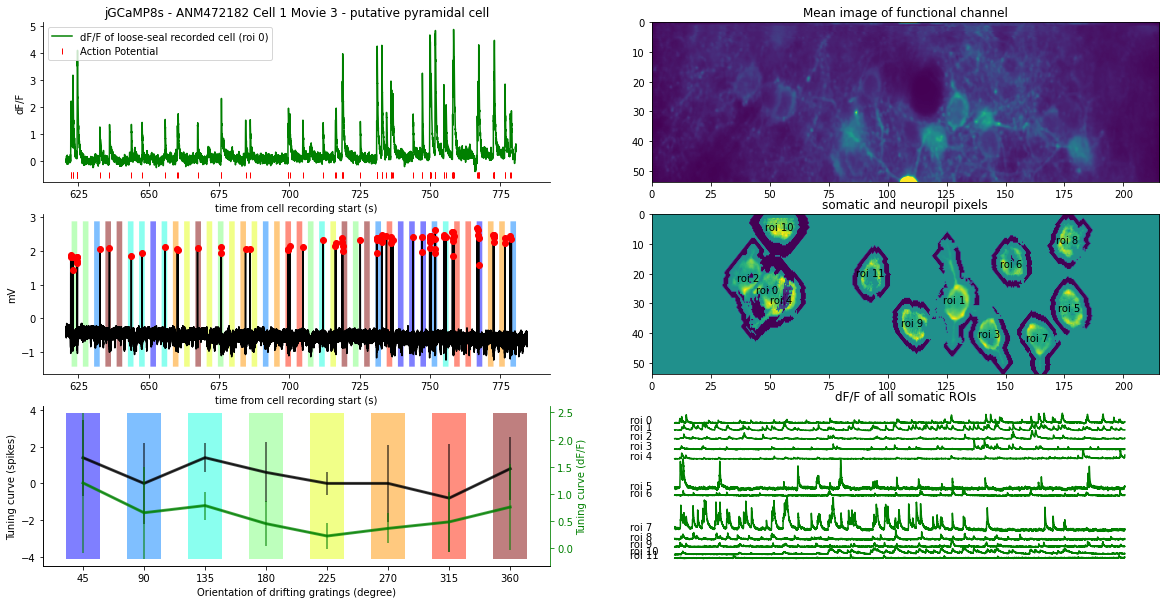

In [17]:
fig = plt.figure(figsize = [20,10])
ax_ophys_all = fig.add_subplot(3,2,6)
ax_roi_shape = fig.add_subplot(3,2,4)
ax_meanimage = fig.add_subplot(3,2,2)
ax_ophys_recorded = fig.add_subplot(3,2,1,sharex = ax_ophys_all)
ax_ephys = fig.add_subplot(3,2,3,sharex = ax_ophys_all)
ax_visual_stim = fig.add_subplot(3,2,5)
ax_visual_stim_dff = ax_visual_stim.twinx()
ax_ephys.plot(ephys_time,ephys_trace,'k-')
ax_ephys.plot(ephys_time[ap_indices],ephys_trace[ap_indices],'ro')
ax_ophys_all.axis('off')

ax_meanimage.set_title('Mean image of functional channel')
ax_ophys_all.set_title('dF/F of all somatic ROIs')
ax_roi_shape.set_title('somatic and neuropil pixels')
ax_ophys_recorded.set_title('{} - ANM{} Cell {} Movie {} - putative {}'.format(sensor,472182,cell_number,movie_number,putative_cell_type))
ax_ophys_recorded.set_ylabel('dF/F')
ax_ophys_recorded.set_xlabel('time from cell recording start (s)')
ax_ophys_recorded.spines['top'].set_visible(False)
ax_ophys_recorded.spines['right'].set_visible(False)
ax_ephys.set_ylabel('{}'.format(ephys_unit))
ax_ephys.set_xlabel('time from cell recording start (s)')
ax_ephys.spines['top'].set_visible(False)
ax_ephys.spines['right'].set_visible(False)
ax_visual_stim.set_xlabel('Orientation of drifting gratings (degree)')
ax_visual_stim.set_ylabel('Tuning curve (spikes)')
ax_visual_stim_dff.set_ylabel('Tuning curve (dF/F)')
ax_visual_stim_dff.spines['right'].set_color('green')
ax_visual_stim_dff.tick_params(axis='y', colors='green')
ax_visual_stim_dff.yaxis.label.set_color('green')
ax_visual_stim.spines['top'].set_visible(False)
ax_visual_stim.spines['right'].set_visible(False)
ax_visual_stim_dff.spines['top'].set_visible(False)

#ax_meanimage.imshow(mean_image_GCaMP)
im_green = ax_meanimage.imshow(mean_image_GCaMP.T, extent=[0,mean_image_GCaMP.shape[0]*float(movie_pixel_size),mean_image_GCaMP.shape[1]*float(movie_pixel_size),0], aspect='auto')
clim = np.percentile(mean_image_GCaMP.flatten(),[.1,99.9])
im_green.set_clim(clim)
im_rois = ax_roi_shape.imshow(roi_image.T, extent=[0,roi_image.shape[0]*float(movie_pixel_size),roi_image.shape[1]*float(movie_pixel_size),0], aspect='auto')
for roi_i,center_idx in enumerate(roi_center_indices):
    ax_roi_shape.text(np.median(center_idx[1])*movie_pixel_size,np.median(center_idx[0])*movie_pixel_size,'roi {}'.format(roi_i),ha="center", va="center")
offset = 0
for roi_i,dff in enumerate(roi_dff_list):
    offset -= np.percentile(dff,100)
    ax_ophys_all.plot(roi_time,dff+offset,'g-',alpha=1)
    ax_ophys_all.text(roi_time[0]-.1*(np.max(roi_time)-np.min(roi_time)),offset,'roi {}'.format(roi_i))
    if roi_i ==0:
        ax_ophys_recorded.plot(roi_time,dff,'g-',alpha=1,label = 'dF/F of loose-seal recorded cell (roi 0)')
        ax_ophys_recorded.plot(ap_times,np.zeros(len(ap_times))-.1*(np.max(dff)-np.min(dff)),'r|',label = 'Action Potential')
        f_corrected_of_recorded_cell = f_corrected
        ax_ophys_recorded.legend()
#%
cmap = colormap.get_cmap('jet')
ylimits_ephys = ax_ephys.get_ylim()
for stim_start_t_now,stim_end_t_now,a in zip(nwbfile.trials['start_time'].data[:],nwbfile.trials['stop_time'].data[:],nwbfile.trials['angle'].data[:]):
    if stim_start_t_now>roi_time[0] and stim_start_t_now<roi_time[-1]:
        ax_ephys.fill_between(ephys_time,
                                    ylimits_ephys[0],
                                    ylimits_ephys[1]   , 
                                    where= (ephys_time > stim_start_t_now) & (ephys_time < stim_end_t_now), 
                                    facecolor=cmap(a/360), #orientation_colors[int(a/45 % 4 -1)],#
                                    alpha=0.5)



ax_visual_stim.plot(unique_angles,ap_mean_list,'k-',linewidth = 3,alpha = .7)
ax_visual_stim.errorbar(unique_angles,ap_mean_list,ap_std_list,color = 'black',alpha = .7)


ax_visual_stim_dff.plot(unique_angles,dff_mean_list,'g-',linewidth = 3,alpha = .7)
ax_visual_stim_dff.errorbar(unique_angles,dff_mean_list,dff_std_list,color = 'green',alpha = .7)

y_limits_visual_stim = ax_visual_stim.get_ylim()
width = 25#np.mean(np.diff(unique_angles))*.8
for a in [45,90,135,180,225,270,315,360]:#range(0,370,10):#unique_angles:
    ax_visual_stim.bar(a,y_limits_visual_stim,width = width,color = cmap(a/360) ,alpha = .5) #cmap(a/360)  orientation_colors[int(a/45 % 4 -1)]
    
ax_visual_stim.set_xticks(unique_angles)

#io.close()

**Top left**: dF/F and action potential times (from ephys) of the loose-seal recorded neuron <br>
**Middle left**: loose-seal recording overlaid with the orientation of the drifting gratings visual stimulus. See colormap on below. Action potential peaks are highlighted with red dots. <br>
**Bottom left**: Tuning curve of the recorded cell calculated from the recording above. Black line is calculated from electrophysiology, green line is calculated from calcium imaging <br>
**Top right**: Mean image of the calcium sensor channel <br>
**Middle right**: ROI (yellow) and neuropil (blue) pixels for each cell. ROI pixels are weighted by the Suite2p pipeline. Each ROI is numbered. <br>
**Bottom rigth**: dF/F for all the ROIs on the panel above.